<a href="https://colab.research.google.com/github/zainabzahara/Solar_Irradiance_Prediction/blob/main/GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install deap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pandas numpy matplotlib torch scikit-learn


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

file_path = '/content/drive/My Drive/Irradiance_Data_23_Copy.xlsx'  # Update this path

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


26/26 [==============================] - 0s 2ms/step
gen	nevals
0  	20    
26/26 [==============================] - 1s 3ms/step
1  	12    
26/26 [==============================] - 1s 3ms/step
2  	16    
26/26 [==============================] - 1s 3ms/step
3  	13    
26/26 [==============================] - 1s 4ms/step
4  	14    
26/26 [==============================] - 1s 3ms/step
5  	14    
26/26 [==============================] - 1s 3ms/step
6  	15    
26/26 [==============================] - 1s 3ms/step
7  	12    
26/26 [==============================] - 1s 2ms/step
8  	14    
26/26 [==============================] - 1s 3ms/step
9  	11    
26/26 [==============================] - 1s 3ms/step
10 	12    
Epoch 1/50
34/34 - 3s - loss: 0.1796 - val_loss: 0.0574 - 3s/epoch - 88ms/step
Epoch 2/50
34/34 - 0s - loss: 0.0591 - val_loss: 0.0305 - 239ms/epoch - 7ms/step
Epoch 3/50
34/34 - 0s - loss: 0.0327 - val_loss: 0.0329 - 266ms/epoch - 8ms/step
Epoch 4/50
34/34 - 0s - loss: 0.0307 - val_l

<ipython-input-9-13ff4932ee24>:154: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100


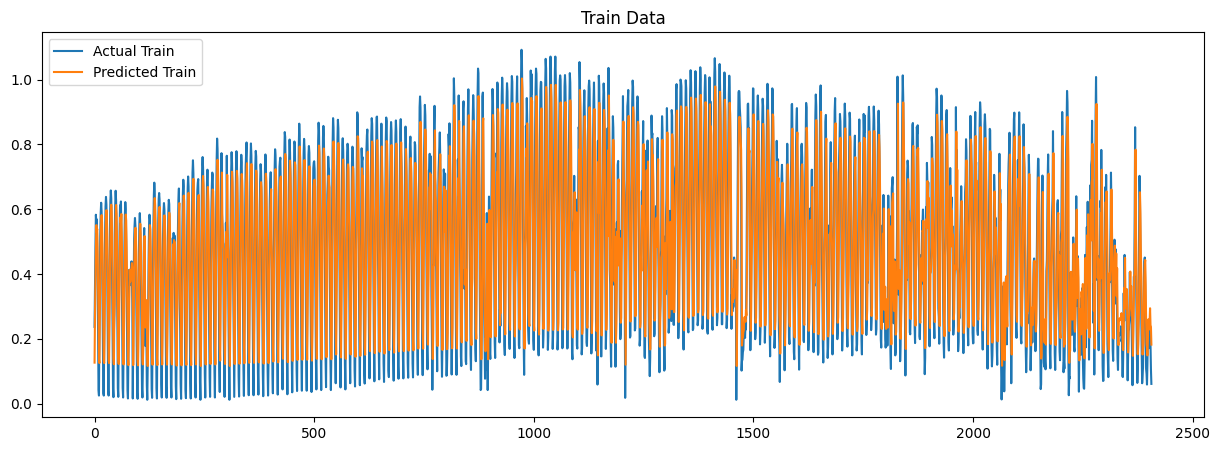

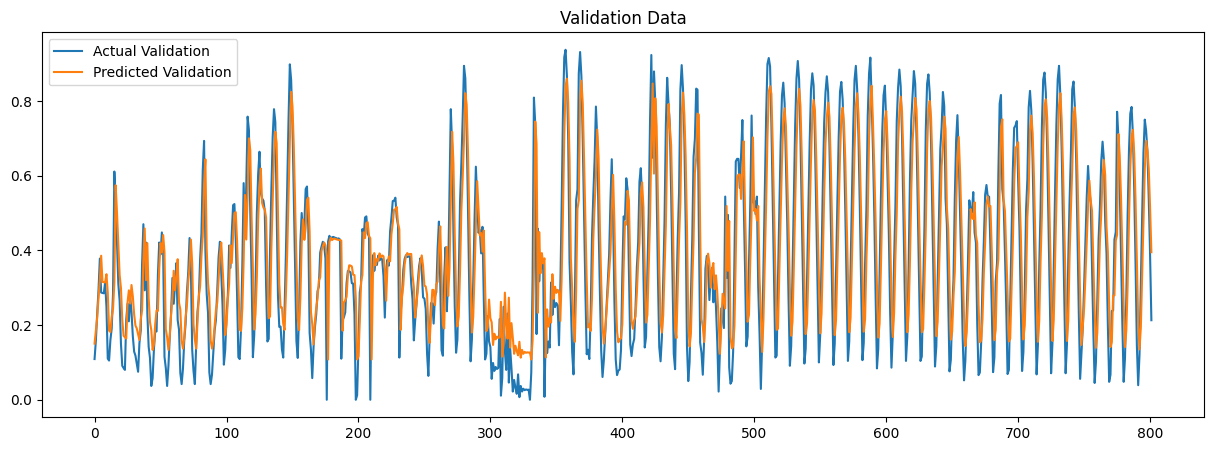

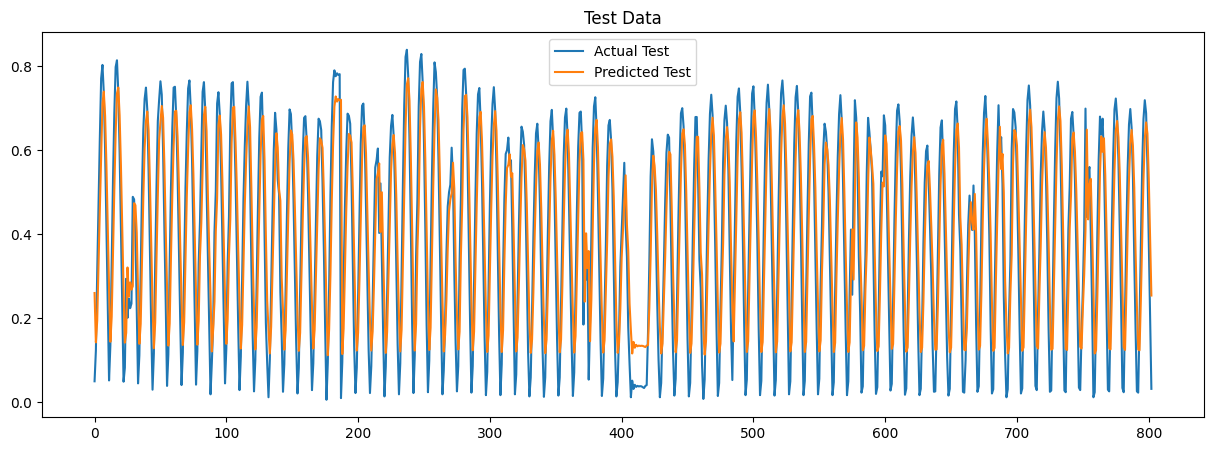

Train Metrics: MSE=0.023463824514674422, RMSE=0.153179060300925, MAE=0.1321779318646717, R2=0.679658245941538, MAPE=60.08340968969523
Validation Metrics: MSE=0.01816513924847315, RMSE=0.1347781111622846, MAE=0.10904959685115742, R2=0.6937319880409942, MAPE=inf
Test Metrics: MSE=0.019073178587416254, RMSE=0.13810567905562846, MAE=0.12100456145801403, R2=0.6822815002971845, MAPE=146.260847008628


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from deap import base, creator, tools, algorithms
import random

# Load the data
file_path = '/content/drive/My Drive/Irradiance_Data_23_Copy.xlsx'  # Update this path
df = pd.read_excel(file_path)

# Correct the column names
df.columns = df.columns.str.strip()

# Parse date and set as index
df['Date / Time'] = pd.to_datetime(df['Date / Time'])
df.set_index('Date / Time', inplace=True)

# Normalize the irradiance values
scaler = MinMaxScaler()
df['irradiance'] = scaler.fit_transform(df[['irradiance']])

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    if isinstance(data, pd.Series):
        data = data.to_frame()

    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Create supervised data
reframed = series_to_supervised(df['irradiance'], 1, 1)
values = reframed.values

# Split the data
n_train = int(len(values) * 0.6)
n_val = int(len(values) * 0.2)
train = values[:n_train, :]
val = values[n_train:n_train + n_val, :]
test = values[n_train + n_val:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Define the model (LSTM for time series prediction)
def create_model(neurons=50, learning_rate=0.01):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Define the fitness function
def fitness_function(individual):
    neurons, learning_rate = individual
    neurons = int(neurons)
    learning_rate = float(learning_rate)

    # Ensure neurons is positive
    if neurons <= 0:
        return float('inf'),  # Return a high penalty if neurons is not positive

    model = create_model(neurons, learning_rate)
    model.fit(train_X, train_y, epochs=10, batch_size=72, verbose=0, shuffle=False)

    val_pred = model.predict(val_X)
    val_mse = mean_squared_error(val_y, val_pred)

    return val_mse,  # Return the validation MSE as the fitness value

# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 10, 100)
toolbox.register("attr_float", random.uniform, 0.001, 0.1)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_float), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", fitness_function)

# Genetic Algorithm run
population = toolbox.population(n=20)
ngen, cxpb, mutpb = 10, 0.5, 0.2

result, log = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=True)

# Extract best individual
best_individual = tools.selBest(population, k=1)[0]
best_neurons, best_learning_rate = int(best_individual[0]), float(best_individual[1])

# Train the final model
final_model = create_model(best_neurons, best_learning_rate)
final_model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)

# Make predictions
train_predictions = final_model.predict(train_X)
val_predictions = final_model.predict(val_X)
test_predictions = final_model.predict(test_X)

# Inverse scaling
train_predictions = scaler.inverse_transform(train_predictions)
val_predictions = scaler.inverse_transform(val_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
train_y = scaler.inverse_transform(train_y.reshape(-1, 1))
val_y = scaler.inverse_transform(val_y.reshape(-1, 1))
test_y = scaler.inverse_transform(test_y.reshape(-1, 1))

# Calculate error metrics
def calculate_metrics(true_values, predictions):
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    return mse, rmse, mae, r2, mape

train_metrics = calculate_metrics(train_y, train_predictions)
val_metrics = calculate_metrics(val_y, val_predictions)
test_metrics = calculate_metrics(test_y, test_predictions)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(train_y, label='Actual Train')
plt.plot(train_predictions, label='Predicted Train')
plt.title('Train Data')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(val_y, label='Actual Validation')
plt.plot(val_predictions, label='Predicted Validation')
plt.title('Validation Data')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(test_y, label='Actual Test')
plt.plot(test_predictions, label='Predicted Test')
plt.title('Test Data')
plt.legend()
plt.show()

# Print the metrics
print(f'Train Metrics: MSE={train_metrics[0]}, RMSE={train_metrics[1]}, MAE={train_metrics[2]}, R2={train_metrics[3]}, MAPE={train_metrics[4]}')
print(f'Validation Metrics: MSE={val_metrics[0]}, RMSE={val_metrics[1]}, MAE={val_metrics[2]}, R2={val_metrics[3]}, MAPE={val_metrics[4]}')
print(f'Test Metrics: MSE={test_metrics[0]}, RMSE={test_metrics[1]}, MAE={test_metrics[2]}, R2={test_metrics[3]}, MAPE={test_metrics[4]}')
